In [1]:

import sys
import os
import numpy as np
import struct
import time
import torch
import argparse
import copy
from collections import OrderedDict
import torchvision.models as models

sys.path.append('/user_data/mmhender/imStat/code/')
from utils import default_paths, torch_utils, nsd_utils
from model_fitting import initialize_fitting

alexnet_conv_layer_names = ['Conv1','Conv1_ReLU','Conv1_MaxPool', \
                       'Conv2','Conv2_ReLU','Conv2_MaxPool', \
                       'Conv3','Conv3_ReLU', \
                       'Conv4','Conv4_ReLU', \
                       'Conv5','Conv5_ReLU','Conv5_MaxPool']

alexnet_fc_layer_names = ['Dropout6','FC6','FC6_ReLU','Dropout7','FC7','FC7_ReLU','FC8']

# Define sets of alexnet layers
n_feature_layers = len(alexnet_conv_layer_names)
n_classif_layers = len(alexnet_fc_layer_names)
n_total_layers = n_feature_layers + n_classif_layers
alexnet_layer_names = copy.deepcopy(alexnet_conv_layer_names)
alexnet_layer_names.extend(alexnet_fc_layer_names)


In [2]:
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: GeForce GTX TITAN X

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [37]:
def get_NCHW_coords(shape, order='F'):
    
    """
    Return coordinates (channel index, position in width dimension, position in height dimension) of feature map units. 
    For feature maps that originally had NCHW shape specified in 'shape', and have been reshaped into a long list of all features.
    Can specify which way the array was reshaped (i.e. when combining all features into a single list) as 'F' or 'C' 
    (see np.reshape for meaning of these)
    """
    
    N = shape[0]
    C = shape[1]
    H = shape[2]
    W = shape[3]
    if order=='F':
        clabs = np.expand_dims(np.tile(np.arange(0,C), W*H), axis=1)
        wlabs = np.expand_dims(np.repeat(np.arange(0,W),C*H),axis=1)  
        hlabs = np.expand_dims(np.repeat(np.tile(np.expand_dims(np.arange(0,H),axis=1),[W,1]), C),axis=1)        
    elif order=='C':
        clabs = np.expand_dims(np.repeat(np.arange(0,C), W*H), axis=1)        
        wlabs = np.expand_dims(np.tile(np.arange(0,W),C*H),axis=1)  
        hlabs = np.expand_dims(np.repeat(np.tile(np.expand_dims(np.arange(0,H),axis=1),[C,1]), W),axis=1)       
       
    # the coords matrix goes [nUnits x 3] where columns are [H,W,C]
    coords = np.concatenate((clabs,hlabs,wlabs),axis=1) 
    print(len(np.unique(coords, axis=0)))
    assert(len(np.unique(coords, axis=0))==C*H*W)

    return coords

In [36]:
# Testing this function.

order='F'
order='C'

shap = [6,5,4,3]
image_ind = 1
coord_ind = 12

coords = get_NCHW_coords(shap, order=order)


thing = np.random.normal(0,1,shap)
print(thing.shape)
print(thing[image_ind,coords[coord_ind,0],coords[coord_ind,1],coords[coord_ind,2]])

thingr = np.reshape(thing, [6,-1], order=order)
print(thingr.shape)
print(thingr[image_ind,coord_ind])

60
(6, 5, 4, 3)
0.3581937444865425
(6, 60)
0.3581937444865425


In [38]:
def get_alexnet_nsd_activations(layer_name, nsd_indices, batch_size=100, debug=False, device=None):

    """
    Get activations for images in NSD, passed through pretrained AlexNet.
    Specify which NSD images to look at, and which layer to return.
    """

    if device is None:
        device = torch.device('cpu:0')
       
    # first loading pre-trained model from torch model zoo
    model = models.alexnet(pretrained=True).double().to(device)
    model.eval()
    model_name='AlexNet'
    
    dset = nsd_utils.nsd_dataset(transform=nsd_utils.get_transform(224), device=device, nsd_inds_include=nsd_indices)
    dloader = nsd_utils.nsd_dataloader(dset, batch_size=batch_size, shuffle=False)
    dgenerator = iter(dloader)
    n_batches = dloader.n_batches
    n_total_images = len(dset)
    
    layer_index = np.where(np.array(alexnet_layer_names)==layer_name)[0][0]
    is_fc = 'FC' in layer_name or 'fc' in layer_name
    
    # first making this subfunction that is needed to get the activation on a forward pass
    def get_activ_fwd_hook(ii):
        def hook(self, input, output):            
            print('hook for %s'%layer_name)           
            activ[ii] = torch_utils.get_value(output)
            print(output.shape)
        return hook
    
    for bb in range(n_batches):
        if bb>1 and debug:
            break

        print('\nGetting activs for batch %d of %d'%(bb, n_batches))
        curr_batch = next(dgenerator)

        # get image and labels for this batch
        # image_tensors is [batch_size x 3 x 224 x 224]
        image_tensors =  curr_batch['image']
        activ = list([[]])
        hook = None

        model.eval()

        # adding this "hook" to the module corresponding to each layer, so we'll save activations at each layer
        # this only modifies the "graph" e.g. what the model code does when run, but doesn't actually run it yet.
        ii=0
        if not is_fc:
            hook = model.features[layer_index].register_forward_hook(get_activ_fwd_hook(ii))
        else:
            hook = model.classifier[layer_index-n_feature_layers].register_forward_hook(get_activ_fwd_hook(ii))

        # do the forward pass of model, which now includes the forward hooks
        # now the "activ" variable will get modified, because it gets altered during the hook function
        model(image_tensors)
        print(activ[ii].shape)
        hook.remove()
        
        if bb==0:
            activ_all = np.zeros([n_total_images, np.prod(activ[ii].shape[1:])])
            if not is_fc:
                coords = get_NCHW_coords(activ[ii].shape, order='F')
            else:
                coords = np.expand_dims(np.arange(0,np.prod(activ[ii].shape[1:])), axis=1)
#         print(activ_all.shape)        
#         print(np.reshape(activ[ii], [batch_size_actual, -1], order='F').shape)
        # full activ here is NCHW format: Batch Size x Channels x Height (top to bottom) x Width (left to right)
        # new activ will be nIms x nFeatures
        batch_size_actual = activ[ii].shape[0]
        activ_all[bb*batch_size:(bb+1)*batch_size,:] = np.reshape(activ[ii], [batch_size_actual, -1], order='F')
  
    return activ_all, coords


In [41]:
debug=True
batch_size=10

device = initialize_fitting.init_cuda()
save_activ_dir = default_paths.alexnet_activ_path

layer_name = alexnet_layer_names[0]
nsd_indices = np.arange(0,15)

activ_all, coords = get_alexnet_nsd_activations(layer_name, nsd_indices, batch_size=batch_size, debug=debug, device=device)
    

#device: 1
device#: 0
device name: GeForce GTX TITAN X

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32
initializing iterator at first batch for nsd dataset
initializing iterator at first batch for nsd dataset

Getting activs for batch 0 of 2

Loading images from brick file at /lab_data/tarrlab/common/datasets/NSD/nsddata_stimuli/stimuli/nsd/nsd_stimuli.hdf5
elapsed time (loading ims): 0.00
block size: (10, 425, 425, 3) , dtype: uint8 , value range: 0 255

Before transformation:
block size: torch.Size([10, 3, 425, 425]) , dtype: torch.float64 , device: cuda:0 , value range: ( 0.0 1.0 )

After transformation:
block size: torch.Size([10, 3, 224, 224]) , dtype: torch.float64 , device: cuda:0 , value range: ( -2.1176664750234155 2.6381327600484634 )
hook for Conv1
torch.Size([10, 64, 55, 55])
(10, 64, 55, 55)
193600

Getting activs for batch 1 of 2

Loading images from brick file at /lab_data/tarrlab/common/datasets/NSD/nsddata_stimuli/stimuli/nsd/nsd_stimuli.hdf5
elapsed t

In [44]:
activ_all

array([[ 0.10294267, -7.74049302, -1.10614025, ...,  9.20178958,
        -2.66798662,  0.39063138],
       [-0.55865028, -9.07925466, -0.33250228, ..., -1.4809709 ,
        -0.34680771, -0.2029671 ],
       [-3.79777378,  0.30770858,  2.21982316, ..., -2.63813201,
         0.17459358,  0.28763262],
       ...,
       [-0.44539814, -5.33055049, -0.48034564, ...,  2.59915765,
        -0.6873804 ,  0.2110964 ],
       [-1.65875898,  0.18734353,  1.10895879, ..., -6.15296477,
         0.07651833, -0.21054986],
       [-1.19561475,  4.34638999, -0.16303708, ..., -9.77393091,
        -1.43407062, -0.84796302]])

In [24]:
# a = np.random.normal(0,1,(1000,64,55,55))
a = np.random.normal(0,1,(1000000,100,10))
print(a.dtype)
print(a.shape)
print(sys.getsizeof(a))
print(a.nbytes)
print(a.nbytes/10**9)

tstsave = os.path.join('/user_data/mmhender/imStat/notebooks/testing/tst.npy')
np.save(tstsave, a)

(1000000, 100, 10)
8000000136
8000000000
8.0


In [27]:
a=a.astype('float32')
print(a.dtype)
print(a.shape)
print(sys.getsizeof(a))
print(a.nbytes)
print(a.nbytes/10**9)

float32
(1000000, 100, 10)
4000000136
4000000000
4.0


In [43]:
a = np.full(shape=(10000,64,55,55), fill_value=1, dtype='float32')
get_size_gb(a)

7.744

In [31]:
def get_size_gb(numpy_array):
    
    return numpy_array.nbytes/10**9

In [36]:
thing = np.load(os.path.join('/lab_data/tarrlab/common/datasets/features/NSD/alexnet', 'feat_alexnet_conv1_avgpool.npy'))

In [40]:
print(thing.dtype)
print(thing.shape)
print(get_size_gb(thing))

float32
(73000, 9216)
2.691072


In [41]:
64*55*55/

144.0

In [26]:
tstsave = os.path.join('/user_data/mmhender/imStat/notebooks/testing/tst.npy')
np.save(tstsave, a.astype('float32'))

In [44]:
model = models.alexnet(pretrained=True).double().to(device)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

[[], [], [], [], [], [], [], [], []]

In [33]:

def merge_alexnet_nsd_activations(save_activ_dir, n_batches, batch_size, alexnet_layer_names, layers2save=None, debug=False):

    """
    Take the output of "get_alexnet_nsd_activations", restructure it into big arrays, and save.
    """
    
    # figure out number of images/number of batches based on dim of the input
#     nbatches = len(all_activ)
    batch_size = np.shape(all_activ[0][0])[0]
    nims = (nbatches-1)*batch_size + np.shape(all_activ[nbatches-1][0])[0]
    nlayers = len(all_activ[0])
    
    if layers2save is None:
        layers2save = np.arange(0,nlayers)
    elif isinstance(layers2save,list):
        layers2save = np.array(layers2save)

    print('Going to save activs for layers:')
    print(np.array(alexnet_layer_names)[layers2save])
    
    model_name='AlexNet'

    # looping over layers, will save separate files for each layer
    for ll in range(nlayers):
        if ll in layers2save:

            # going to loop over batches and put the whole big matrix back together 
            if len(all_activ[0][ll].shape)==2:
                activ= np.zeros([nims, np.shape(all_activ[0][ll])[1]])
            else:
                activ= np.zeros([nims, np.shape(all_activ[0][ll])[1], 
                                 np.shape(all_activ[0][ll])[2],np.shape(all_activ[0][ll])[3]])
            for bb in range(nbatches):
                if bb>1 and debug:
                    break
                if len(all_activ[0][ll].shape)==2:
                    activ[bb*batch_size:(bb+1)*batch_size,:] = torch_utils.get_value(all_activ[bb][ll])
                else:
                    activ[bb*batch_size:(bb+1)*batch_size,:,:,:] = torch_utils.get_value(all_activ[bb][ll])

            # note these are very big files! probably don't want to save every layer.
            print('\nsaving activs for layer %s, size is:'%alexnet_layer_names[ll])
            print(np.shape(activ))
            fn2save = os.path.join(save_activ_dir, '%s_%s_fullactiv.npy'%(model_name,alexnet_layer_names[ll]))
            np.save(fn2save, activ)
            print('saved!')
            
        else:
            continue
            
    print('done saving!')
    

In [ ]:
def get_alexnet_nsd_activations(save_activ_dir, batch_size=100, nsd_inds_include=None, debug=False, device=None):

    """
    Get activations for images in NSD, passed through pretrained AlexNet.
    can specify which nsd images to look at - if nsd_inds_include=None, then using all.
    Returns a nested ordered dict of activations, put this into array format with 'save_alexnet_nsd_activations'
    """

    if device is None:
        device = torch.device('cpu:0')
        
    # first loading pre-trained model from torch model zoo
    model = models.alexnet(pretrained=True).double().to(device)
    model.eval()

    dset = nsd_utils.nsd_dataset(transform=nsd_utils.get_transform(224), device=device, nsd_inds_include=nsd_inds_include)
    dloader = nsd_utils.nsd_dataloader(dset, batch_size=batch_size, shuffle=False)
    dgenerator = iter(dloader)
    n_batches = dloader.n_batches

    # will loop over all the layers in the "features" module (which is a Sequential container of modules)
    n_feature_layers = len(alexnet_conv_layer_names)
    n_classif_layers = len(alexnet_fc_layer_names)
    n_total_layers = n_feature_layers + n_classif_layers
    alexnet_layer_names = copy.deepcopy(alexnet_conv_layer_names)
    alexnet_layer_names.extend(alexnet_fc_layer_names)

    # first making this subfunction that is needed to get the activation on a forward pass
    def get_activ_fwd_hook(ii):
        def hook(self, input, output):            
#             print('hook for %s'%alexnet_layer_names[ii])           
#             activ[ii] = output
            activ[ii] = torch_utils.get_value(output)
#             print(output.shape)
        return hook
    
    # initialize this - will be big nested ordereddict to store all activs
#     all_activ = [[np.zeros((n_total_images, )]
#     all_activ = list([[] for ii in range(n_batches)])
#     n_total_images = 
#     all_activ = np.zeros((n_total_images))

    for bb in range(n_batches):
        if bb>1 and debug:
            break

        print('\nGetting activs for batch %d of %d'%(bb, n_batches))
        curr_batch = next(dgenerator)

        # get image and labels for this batch
        # image_tensors is [batch_size x 3 x 224 x 224]
        image_tensors =  curr_batch['image']
        hooks = list([[] for ii in range(n_total_layers)])
        activ = list([[] for ii in range(n_total_layers)])

        model.eval()
        # adding this "hook" to the module corresponding to each layer, so we'll save activations at each layer
        # this only modifies the "graph" e.g. what the model code does when run, but doesn't actually run it yet.
        for ii in range(n_total_layers):  
            if ii<n_feature_layers:
                hooks[ii] = model.features[ii].register_forward_hook(get_activ_fwd_hook(ii))
            else:
                hooks[ii] = model.classifier[ii-n_feature_layers].register_forward_hook(get_activ_fwd_hook(ii))

        # do the forward pass of model, which now includes the forward hooks
        # now the "activ" variable will get modified, because it gets altered during the hook function
        model(image_tensors)

#         all_activ[bb] = activ
        
#         if bb==0:
#             if np.shape(activ)
#             all_activ.append(np.w)
        # removing the hooks now, because otherwise they get added multiple times
        for ii in range(n_total_layers):
            hooks[ii].remove()
            
        # now save the files (temporarily)
        for ll in range(nlayers):
            if ll in layers2save:
                # note these are very big files! probably don't want to save every layer.
                print('\nsaving activs for layer %s, size is:'%alexnet_layer_names[ll])
                print(np.shape(activ))
                fn2save = os.path.join(save_activ_dir, 'batches_tmp','batch%d_%s_%s_fullactiv.npy'%(bb,model_name,alexnet_layer_names[ll]))
                np.save(fn2save, activ[ll])
                print('saved!')
            else:
                continue


In [17]:
all_activ[0][18].shape

torch.Size([100, 4096])

In [34]:
all_activ, alexnet_layer_names = get_alexnet_nsd_activations(batch_size=100, nsd_inds_include=None, debug=True)

initializing iterator at first batch for nsd dataset
initializing iterator at first batch for nsd dataset

Getting activs for batch 0 of 730

Loading images from brick file at /lab_data/tarrlab/common/datasets/NSD/nsddata_stimuli/stimuli/nsd/nsd_stimuli.hdf5
elapsed time (loading ims): 0.08
block size: (100, 425, 425, 3) , dtype: uint8 , value range: 0 255

Before transformation:
block size: torch.Size([100, 3, 425, 425]) , dtype: torch.float64 , device: cpu , value range: ( 0.0 1.0 )

After transformation:
block size: torch.Size([100, 3, 224, 224]) , dtype: torch.float64 , device: cpu , value range: ( -2.1176664750234155 2.6381327600484634 )

Getting activs for batch 1 of 730

Loading images from brick file at /lab_data/tarrlab/common/datasets/NSD/nsddata_stimuli/stimuli/nsd/nsd_stimuli.hdf5
elapsed time (loading ims): 0.08
block size: (100, 425, 425, 3) , dtype: uint8 , value range: 0 255

Before transformation:
block size: torch.Size([100, 3, 425, 425]) , dtype: torch.float64 , devi

In [35]:
save_activ_dir = default_paths.alexnet_activ_path
layers2save = [1,4,7,9,11,15,18]
save_alexnet_nsd_activations(save_activ_dir=save_activ_dir, all_activ=all_activ, alexnet_layer_names=alexnet_layer_names, layers2save = layers2save, debug=True)

Going to save activs for layers:
['Conv1_ReLU' 'Conv2_ReLU' 'Conv3_ReLU' 'Conv4_ReLU' 'Conv5_ReLU'
 'FC6_ReLU' 'FC7_ReLU']

saving activs for layer Conv1_ReLU, size is:
(200, 64, 55, 55)
saved!

saving activs for layer Conv2_ReLU, size is:
(200, 192, 27, 27)
saved!

saving activs for layer Conv3_ReLU, size is:
(200, 384, 13, 13)
saved!

saving activs for layer Conv4_ReLU, size is:
(200, 256, 13, 13)
saved!

saving activs for layer Conv5_ReLU, size is:
(200, 256, 13, 13)
saved!

saving activs for layer FC6_ReLU, size is:
(200, 4096)
saved!

saving activs for layer FC7_ReLU, size is:
(200, 4096)
saved!
done saving!


In [12]:
nd = nsd_dataset(transform=get_transform(224), device=device)
nd.nsd_brick_file
t = time.time()
item = nd[np.arange(0,200)]
elapsed = time.time()-t
print('elapsed time is %.5f'%elapsed)

loading images from brick file at /lab_data/tarrlab/common/datasets/NSD/nsddata_stimuli/stimuli/nsd/nsd_stimuli.hdf5
elapsed time (loading ims): 0.15
block size: (200, 425, 425, 3) , dtype: uint8 , value range: 0 255
elapsed time is 3.55580


In [31]:
nd.stim_info.keys()

Index(['cocoId', 'cocoSplit', 'cropBox', 'loss', 'nsdId', 'flagged',
       'BOLD5000', 'shared1000', 'subject1', 'subject2', 'subject3',
       'subject4', 'subject5', 'subject6', 'subject7', 'subject8',
       'subject1_rep0', 'subject1_rep1', 'subject1_rep2', 'subject2_rep0',
       'subject2_rep1', 'subject2_rep2', 'subject3_rep0', 'subject3_rep1',
       'subject3_rep2', 'subject4_rep0', 'subject4_rep1', 'subject4_rep2',
       'subject5_rep0', 'subject5_rep1', 'subject5_rep2', 'subject6_rep0',
       'subject6_rep1', 'subject6_rep2', 'subject7_rep0', 'subject7_rep1',
       'subject7_rep2', 'subject8_rep0', 'subject8_rep1', 'subject8_rep2'],
      dtype='object')

In [37]:

nd = nsd_dataset(transform=get_transform(224), device=device, nsd_inds_include = np.array((10,12,200,1,5,70000)))
batch_size=5
dloader = nsd_dataloader(nd, batch_size=batch_size, shuffle=False)
dgenerator = iter(dloader)

t = time.time()
item = next(dgenerator)
elapsed = time.time()-t
print('elapsed time is %.5f'%elapsed)

print(item['coco_id'])
print(item['nsd_id'])
# t = time.time()
# next(dgenerator)
# elapsed = time.time()-t
# print('elapsed time is %.5f'%elapsed)

# t = time.time()
# next(dgenerator)
# elapsed = time.time()-t
# print('elapsed time is %.5f'%elapsed)

[   10    12   200     1     5 70000]
initializing iterator at first batch for nsd dataset
initializing iterator at first batch for nsd dataset
batch inds:
[0 1 2 3 4]
5
sample inds:
[0 1 2 3 4]
5
[ 10  12 200   1   5]
loading images from brick file at /lab_data/tarrlab/common/datasets/NSD/nsddata_stimuli/stimuli/nsd/nsd_stimuli.hdf5
elapsed time (loading ims): 0.01
block size: (5, 425, 425, 3) , dtype: float64 , value range: 0.0 255.0

Before transformation:
block size: torch.Size([5, 3, 425, 425]) , dtype: torch.float64 , device: cuda:0 , value range: ( 0.0 1.0 )

After transformation:
block size: torch.Size([5, 3, 224, 224]) , dtype: torch.float64 , device: cuda:0 , value range: ( -2.1176654511422472 2.6399999999999997 )
elapsed time is 0.03068
10     376856
12     372349
200    459662
1      245764
5      475150
Name: cocoId, dtype: int64
10      10
12      12
200    200
1        1
5        5
Name: nsdId, dtype: int64


In [42]:

nd = nsd_dataset(transform=get_transform(224), device=device)
batch_size=5
dloader = nsd_dataloader(nd, batch_size=batch_size, shuffle=False)
dgenerator = iter(dloader)

t = time.time()
item = next(dgenerator)
elapsed = time.time()-t
print('elapsed time is %.5f'%elapsed)

print(item['coco_id'])
print(item['nsd_id'])
# t = time.time()
# next(dgenerator)
# elapsed = time.time()-t
# print('elapsed time is %.5f'%elapsed)

# t = time.time()
# next(dgenerator)
# elapsed = time.time()-t
# print('elapsed time is %.5f'%elapsed)

[    0     1     2 ... 72997 72998 72999]
initializing iterator at first batch for nsd dataset
initializing iterator at first batch for nsd dataset
batch inds:
[0 1 2 3 4]
5
sample inds:
[0 1 2 3 4]
5
[0 1 2 3 4]
loading images from brick file at /lab_data/tarrlab/common/datasets/NSD/nsddata_stimuli/stimuli/nsd/nsd_stimuli.hdf5
elapsed time (loading ims): 0.00
block size: (5, 425, 425, 3) , dtype: uint8 , value range: 0 255

Before transformation:
block size: torch.Size([5, 3, 425, 425]) , dtype: torch.float64 , device: cuda:0 , value range: ( 0.0 1.0 )

After transformation:
block size: torch.Size([5, 3, 224, 224]) , dtype: torch.float64 , device: cuda:0 , value range: ( -2.1176664750234155 2.6381327600484634 )
elapsed time is 0.02393
0    532481
1    245764
2    385029
3    311303
4    393226
Name: cocoId, dtype: int64
0    0
1    1
2    2
3    3
4    4
Name: nsdId, dtype: int64


In [39]:
len(dgenerator)

2

In [28]:
stim_info['cocoId'][np.array((10,12,200,1,5,70000))]

10       376856
12       372349
200      459662
1        245764
5        475150
70000    244206
Name: cocoId, dtype: int64

In [ ]:
for bb in dloader.n_batches:
    
    next(iter(dloader))

In [ ]:
np.all(np.diff(nsd_indices)==1) or len(nsd_indices)==1

In [40]:
#

In [180]:
73000/200

365.0

In [170]:

# create a dataloader object that breaks whole set into smaller batches
batch_size=200
# note this is NOT shuffled, so we will know exactly which images are in which batch
dloader = DataLoader(nd, batch_size = batch_size, shuffle=False)
dgenerator = iter(dloader)
nbatches = len(dloader)


In [41]:
t=time.time()
# dgenerator.next()
elapsed = time.time()-t
print('elapsed time is %.5f'%elapsed)

elapsed time is 0.00004


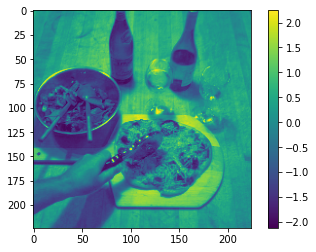

In [113]:
im1 = torch_utils.get_value(item['image'][2,0])
np.mean(im1)

plt.figure();
plt.imshow(im1);
plt.colorbar()

(array([ 1530.,  6500.,  5317.,  3741.,  5514., 13281.,  9594.,  3237.,
         1239.,   223.]),
 array([-2.11741016, -1.68121756, -1.24502496, -0.80883236, -0.37263976,
         0.06355284,  0.49974544,  0.93593804,  1.37213064,  1.80832325,
         2.24451585]),
 <BarContainer object of 10 artists>)

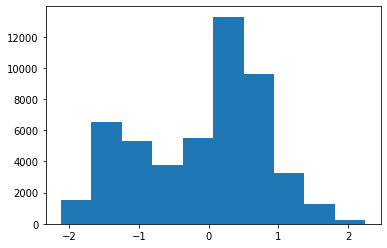

In [114]:
plt.figure();
plt.hist(np.ravel(im1))

In [137]:

t = time.time()
item = next(dgenerator)
elapsed = time.time()-t
print('elapsed time is %.5f'%elapsed)

torch.Size([10, 1, 3, 224, 224])

In [67]:
model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [66]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [76]:
n_feature_layers

20

In [18]:
for ll in range(len(alexnet_layer_names)):
    print(alexnet_layer_names[ll])
    print(all_activ[0][ll].shape)

Conv1
torch.Size([100, 64, 55, 55])
Conv1_ReLU
torch.Size([100, 64, 55, 55])
Conv1_MaxPool
torch.Size([100, 64, 27, 27])
Conv2
torch.Size([100, 192, 27, 27])
Conv2_ReLU
torch.Size([100, 192, 27, 27])
Conv2_MaxPool
torch.Size([100, 192, 13, 13])
Conv3
torch.Size([100, 384, 13, 13])
Conv3_ReLU
torch.Size([100, 384, 13, 13])
Conv4
torch.Size([100, 256, 13, 13])
Conv4_ReLU
torch.Size([100, 256, 13, 13])
Conv5
torch.Size([100, 256, 13, 13])
Conv5_ReLU
torch.Size([100, 256, 13, 13])
Conv5_MaxPool
torch.Size([100, 256, 6, 6])
Dropout6
torch.Size([100, 9216])
FC6
torch.Size([100, 4096])
FC6_ReLU
torch.Size([100, 4096])
Dropout7
torch.Size([100, 4096])
FC7
torch.Size([100, 4096])
FC7_ReLU
torch.Size([100, 4096])
FC8
torch.Size([100, 1000])


In [19]:
len(all_activ[0][ll].shape)

2